In [1]:
import sys
# sys.stdout = open('logfile', 'w')
sys.path.append('..')

import attack
import data_loader as dl

In [2]:
import geopandas as gp
import pandas as pd
from tqdm import tqdm
import numpy as np
import libpysal
import itertools
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt

In [3]:
# Load preprocessed data 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = dl.load_freemove(data_type='private', 
                                                                                       min_n_trips_per_user=1,
                                                                                       rand_n_week_period=None,
                                                                                       tessellation_diameter=200,
                                                                                       min_trip_length=200,
                                                                                       min_nr_points=20,
                                                                                       upper_quantile_nr_points=0.95,
                                                                                       hide_test_users=False)
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

Reading private freemove geojson file...
Done.
Number of trajectories in loaded dataset: 994
Number of users in loaded dataset: 70


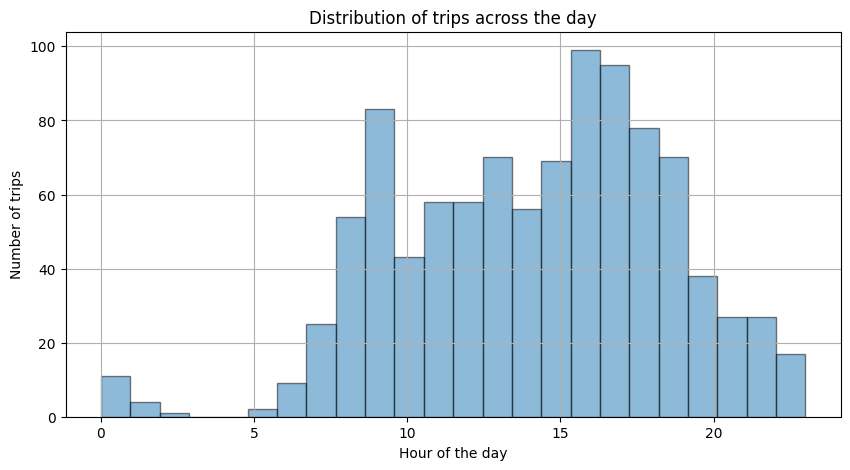

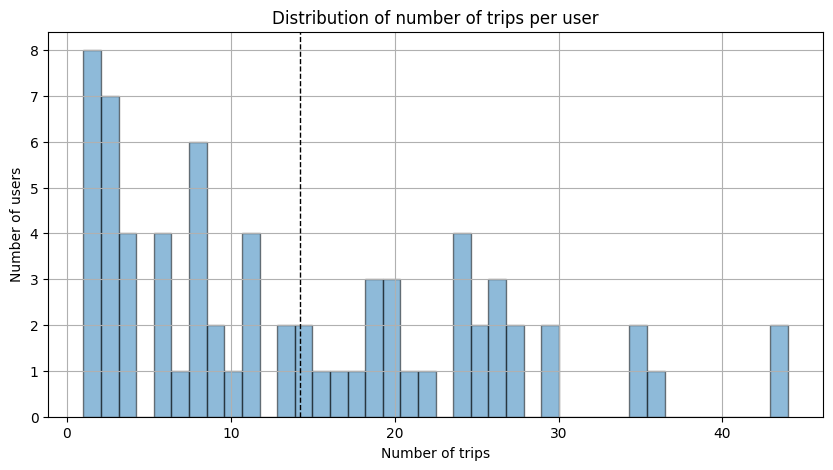

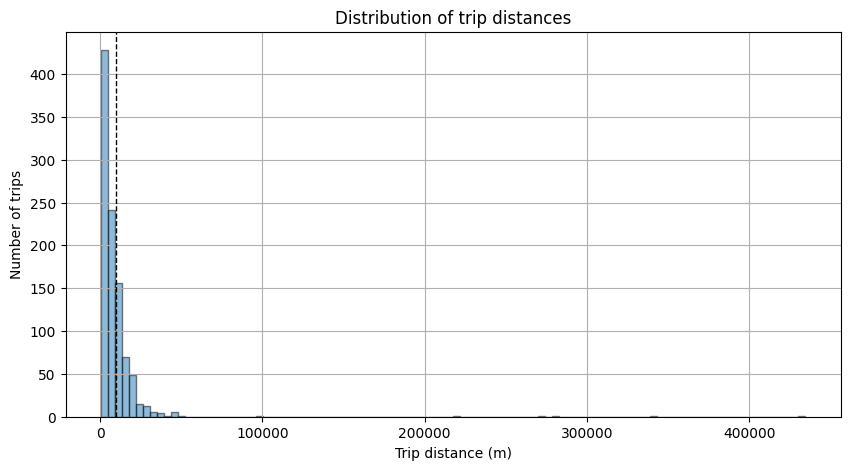

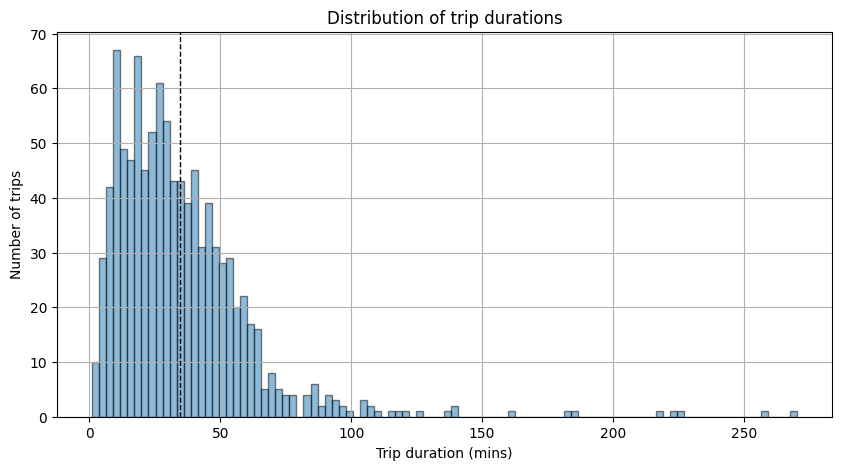


Matching start and end points with tessellation...


In [ ]:
# Parameters
LCSS_EPS = 200
LCSS_FLIP = True

HL_SP_START_TIME = '6:00'
HL_SP_END_TIME = '10:00'
HL_EP_START_TIME = '18:00'
HL_EP_END_TIME = '0:00'

CHAINING_INFLOW_HR_DIFF_THRESHOLD = 4
CHAINING_HR_DIFF_THRESHOLD = 8

HL_SP_OUTFLOW_THRESHOLD = 2
HL_EP_OUTFLOW_THRESHOLD = 4

RANDOMIZED_SIMULTANEOUS_SEARCH_ITERATIONS = 1000

SIM_THRESH_FOR_NO_MATCH_TRIPS = 0.5

# JSD Parameters
GRID_RESOLUTION_JSD = 1000

attack.plot_hour_of_day_distribution(raw_full_trip_gdf)
attack.plot_distribution_of_number_of_trips_per_user(raw_full_trip_gdf)
attack.plot_distribution_of_trip_distances(raw_full_trip_gdf)
attack.plot_distribution_of_trip_durations(raw_full_trip_gdf)

# Merge Start Points (SP) and End Points (EP) with Tessellation
print("\nMatching start and end points with tessellation...")
gdf_sp, gdf_ep = attack.match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)
print("Done.")

# Extract Full Trips that Start and End within Tessellation Area
print("\nExtracting trips that start and end within tessellation area...")
full_trip_gdf, trip_sp_gdf, trip_ep_gdf, gdf_sp, gdf_ep = attack.extract_trips_that_start_end_in_tessellation(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, gdf_sp, gdf_ep)
print("Done.")

# Build mapping of trip chains
print('\nBuilding mapping of trip chains...')
mapping_cont_trips = attack.build_trip_chain_mapping(gdf_sp, gdf_ep)
print('Done.')

# Evaluate Trip Chaining
print('\nEvaluating trip chaining...')
attack.evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)
print('Done.')

# Concatenate Trips
full_trips_concat_gdf, trip_concat_dict = attack.merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)

# Extract data for concatenated trips
print('\nExtracting data for concatenated trips...')
gdf_sp_concat, trip_sp_gdf_concat, gdf_ep_concat, trip_ep_gdf_concat = attack.extract_concatenated_trips(full_trips_concat_gdf, gdf_sp, trip_sp_gdf, gdf_ep, trip_ep_gdf)
print('Done.')

# Build Clustering after Concatenation step
print('\nBuilding clustering after concatenation...')
clustering_concat = attack.build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict, full_trip_gdf)
print('Done.')

# Build Home Locations (HL)
# Build HL from Start Points
print('\nBuilding HL from start points...')
gdf_hl_combined_sp = attack.build_hl_from_start_points(gdf_sp, gdf_ep, HL_SP_OUTFLOW_THRESHOLD=HL_SP_OUTFLOW_THRESHOLD)
print('Done.')
# Build HL from End Points
print('\nBuilding HL from end points...')
gdf_hl_combined_ep = attack.build_hl_from_end_points(gdf_sp, gdf_ep, HL_EP_OUTFLOW_THRESHOLD=HL_EP_OUTFLOW_THRESHOLD)
print('Done.')
# Combine HL from Start Points and End Points
print('\nCombining HL from start points and end points...')
gp_combined, HL_table = attack.concatenate_hl(gdf_hl_combined_sp, gdf_hl_combined_ep)
print('Done.')

print('\nMatching trips to HL...')
HL_table_se_concat, unmatched_trips, double_assigned_trips, nr_unmatched = attack.match_trips_to_HL(gp_combined, HL_table, trip_sp_gdf_concat, trip_ep_gdf_concat, full_trips_concat_gdf)
print('Done.')

print('\nMatching double assigned trips to unique HL...')
HL_table_trips_concat = attack.assign_double_matched_trips_to_unique_hl(HL_table_se_concat, full_trips_concat_gdf, unmatched_trips, double_assigned_trips, nr_unmatched)
print('Done.')

# Get trajectories that happened during the same time
print('\nGetting trajectories that happened during the same time...')
full_trips_concat_gdf_overlap_dict = attack.getTripOverlaps(full_trips_concat_gdf)
print('Done.')

# Build Clustering after HL matching step
print('\nBuilding clustering after HL matching step...')
clustering_after_HL, HL_table_dict = attack.build_clustering_after_HL_assignment(HL_table_trips_concat, full_trip_gdf, trip_concat_dict, full_trips_concat_gdf_overlap_dict)
print('Done.')

# Evaluate clustering Results
print("\nClustering results after concatenation step:")
print(f"Number of unique clusters: {len(set(clustering_concat))}")
attack.evaluate(clustering_concat, full_trip_gdf)
clustering_HL = list(dict(sorted(clustering_after_HL.items())).values())
print("\nClustering results after HL matching step:")
print(f"Number of unique clusters: {len(set(clustering_HL))}")
attack.evaluate(clustering_HL, full_trip_gdf)

In [ ]:
full_trip_gdf = full_trip_gdf.copy()
full_trip_gdf['clustering_HL'] = clustering_HL
full_trip_gdf.to_file('../data/freemove/freemove_clustering_HL_private.geojson', driver="GeoJSON")

In [17]:
import movingpandas as mpd
test = full_trip_gdf.to_crs(4326)

In [101]:
from skmob.tessellation import tilers
import skmob
from shapely.geometry import Polygon


MIN_LNG, MIN_LAT, MAX_LNG, MAX_LAT = 12.562133, 52.099718, 14.129426, 52.803108  # raw_points_gdf.geometry.total_bounds

TILE_DIAMETER_IN_METERS = (
    300  # approximately. For h3 the most appropriate resolution is found
)
TILE_TYPE = "h3_tessellation"  # other option: "squared", "h3_tessellation"
####################################################################

base_shape = gp.GeoDataFrame(
    index=[0],
    crs=4326,
    geometry=[
        Polygon(
            zip(
                [MIN_LNG, MAX_LNG, MAX_LNG, MIN_LNG],
                [MIN_LAT, MIN_LAT, MAX_LAT, MAX_LAT],
            )
        )
    ],
)

tessellation = tilers.tiler.get(
    TILE_TYPE,
    base_shape=base_shape,
    meters=TILE_DIAMETER_IN_METERS,
).drop('H3_INDEX', axis=1)

/usr/local/lib/python3.8/dist-packages/skmob/tessellation/tilers.py:243: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


In [48]:
import itertools


test = [1,2,3]
comb = itertools.combinations(test, 3)

for i in comb:
    print(list(i))

[1, 2, 3]


In [22]:
def get_conflicts_length(trip_id_set, full_trips_concat_gdf_overlap_dict):
        conflicting_ids = []
        for tid in trip_id_set:
            conflicting_ids.append([k for k in trip_id_set if tid in full_trips_concat_gdf_overlap_dict[k]])
        return len([item for sublist in conflicting_ids for item in sublist])
    
def find_nonsim_subset(trip_id_set, full_trips_concat_gdf_overlap_dict):
    print('Initial Length', len(trip_id_set))
    dropped_ids = []
    while True:
        # get conflicting ids
        conflicting_ids = []
        for tid in trip_id_set:
            conflicting_ids.append([k for k in trip_id_set if tid in full_trips_concat_gdf_overlap_dict[k]])

        conflict_len = len([item for sublist in conflicting_ids for item in sublist])

        if conflict_len == 0:
            print("Done. Best length: ", len(trip_id_set))
            break

        combinations = list(itertools.combinations(trip_id_set, len(trip_id_set)-1))
        best_combination = np.argmax([conflict_len - get_conflicts_length(t_id_set, full_trips_concat_gdf_overlap_dict) for t_id_set in combinations])

        for i in trip_id_set:
            if i not in combinations[best_combination]:
                dropped_ids.append(i)
        trip_id_set = combinations[best_combination]
    return trip_id_set, dropped_ids

for HL in HL_table_trips_concat.HL_ID.unique():
    print(HL)
    trip_id_set = set(HL_table_trips_concat.query('HL_ID == @HL').TRIP_ID.tolist()) 
    
    new_clusters = []
    
    while True:
        best, dropped = find_nonsim_subset(trip_id_set, full_trips_concat_gdf_overlap_dict)
        
        new_clusters.append(best)
        
        if len(dropped) > 0:
            trip_id_set = dropped
        else:
            break
            
    print(len(new_clusters))       
    
            

159.0
Initial Length 2
Done. Best length:  2
1
4.0
Initial Length 32
Done. Best length:  27
Initial Length 5
Done. Best length:  4
Initial Length 1
Done. Best length:  1
3
137.0
Initial Length 13
Done. Best length:  13
1
116.0
Initial Length 40
Done. Best length:  33
Initial Length 7
Done. Best length:  7
2
171.0
Initial Length 18
Done. Best length:  18
1
129.0
Initial Length 23
Done. Best length:  21
Initial Length 2
Done. Best length:  2
2
198.0
Initial Length 2
Done. Best length:  2
1
68.0
Initial Length 2
Done. Best length:  2
1
63.0
Initial Length 7
Done. Best length:  6
Initial Length 1
Done. Best length:  1
2
70.0
Initial Length 1
Done. Best length:  1
1
13.0
Initial Length 29
Done. Best length:  27
Initial Length 2
Done. Best length:  2
2
210.0
Initial Length 14
Done. Best length:  14
1
20.0
Initial Length 14
Done. Best length:  13
Initial Length 1
Done. Best length:  1
2
202.0
Initial Length 8
Done. Best length:  8
1
41.0
Initial Length 6
Done. Best length:  6
1
67.0
Initial L

In [21]:
best

{102, 111}

In [ ]:

m = tessellation.explore()

full_trips_concat_gdf.query('TRIP_ID in @ids')[['PERSON_ID', 'TRIP_ID', 'geometry']].astype({'PERSON_ID': 'object'}).explore(m=m, column='PERSON_ID')


In [ ]:
ids = HL_table_trips_concat.query('HL_ID == 100').TRIP_ID


m = tessellation.explore()

full_trips_concat_gdf.query('TRIP_ID in @ids')[['PERSON_ID', 'TRIP_ID', 'geometry']].astype({'PERSON_ID': 'object'}).explore(m=m, column='PERSON_ID')


In [9]:
full_trips_concat_gdf_overlap_dict[171]

[146, 192, 177, 193, 182, 173, 191, 195, 179, 187, 524, 172, 175]

In [7]:
trip_concat_dict[396]

[398]

In [8]:
for k, v in trip_concat_dict.items():
    if 1109 in v:
        print(k,v)
        break

1104 [1109]


In [7]:
full_trips_concat_gdf.query('TRIP_ID in [187, 171]')

,TRIP_ID,TRIP_START,TRIP_END,TRIP_LEN_IN_MTRS,PERSON_ID,geometry,TRIP_WD,TRIP_DATE,TRIP_DURATION_IN_MINS,HOUR,TRIP_ID_LAST,TRIP_ID_FIRST
495,187,2022-11-01T17:41:22,2022-11-01T18:52:35,33790.809521,16972,"LINESTRING (4546953.889 3272297.297, 4546955.0...",Tuesday,2022-11-01,[71.21666666666667],[17],187.0,187
619,171,2022-11-01T17:57:36,2022-11-01T18:21:19,4875.929033,16354,"LINESTRING (4550408.149 3270065.775, 4550411.0...",Tuesday,2022-11-01,[23.716666666666665],[17],171.0,171


In [5]:
def find_nr_overlaps(cl_i, cl_j, gdf):
    nr_overlaps = 0
    
    gdf['TRIP_START'] = pd.to_datetime(gdf['TRIP_START'], format='%Y-%m-%d %H:%M:%S')
    gdf['TRIP_END'] = pd.to_datetime(gdf['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
    
    cl_i_trips = gdf.query("clustering_HL == @cl_i").copy()
    cl_j_trips = gdf.query("clustering_HL == @cl_j").copy()
        
    for i, t_i in cl_i_trips.iterrows():
        t_i_s_x = t_i
        t_i_e_x = pd.to_datetime(t_i['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
        
        for i, t_j in cl_j_trips.iterrows():
            if t_i.TRIP_START <= t_j.TRIP_START and t_i.TRIP_END >= t_j.TRIP_START and (t_i.TRIP_ID != t_j.TRIP_ID):
                print('Overlapping trips in two clusters! Not merging these...')
                print(t_i.TRIP_ID, t_j.TRIP_ID)
                nr_overlaps += 1
                
    return nr_overlaps

In [12]:
for cl_id in full_trip_gdf.clustering_HL.unique():
    if find_nr_overlaps(cl_id,cl_id, full_trip_gdf) > 0:
        print(cl_id)
        print("error")

Overlapping trips in two clusters! Not merging these...
187 171
149
error


In [114]:
full_trip_gdf.clustering_HL.nunique()

916

In [115]:
full_trip_gdf.to_file('full_trip_concat_clustering.geojson', driver='GeoJSON')

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


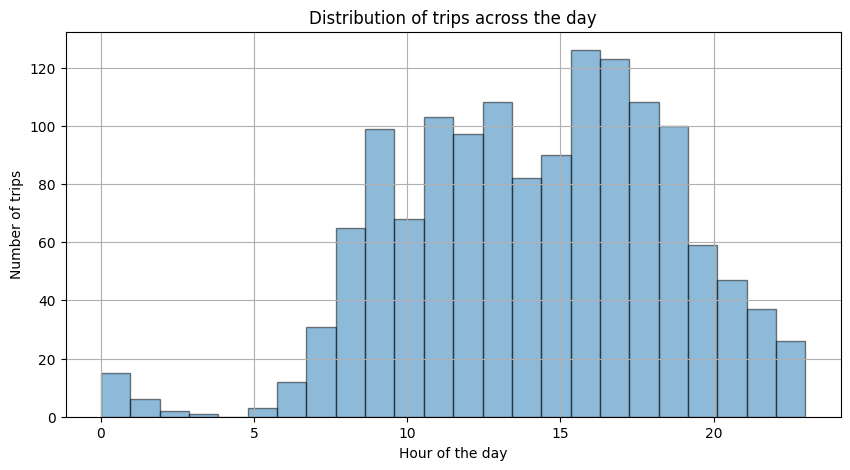

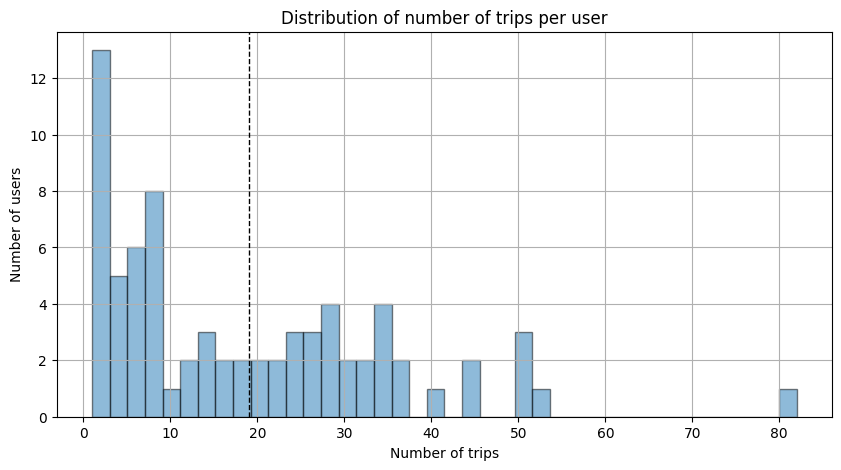

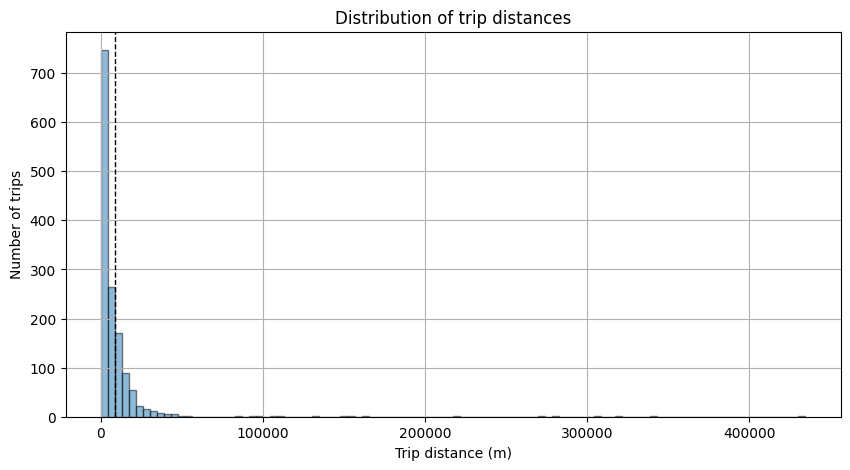

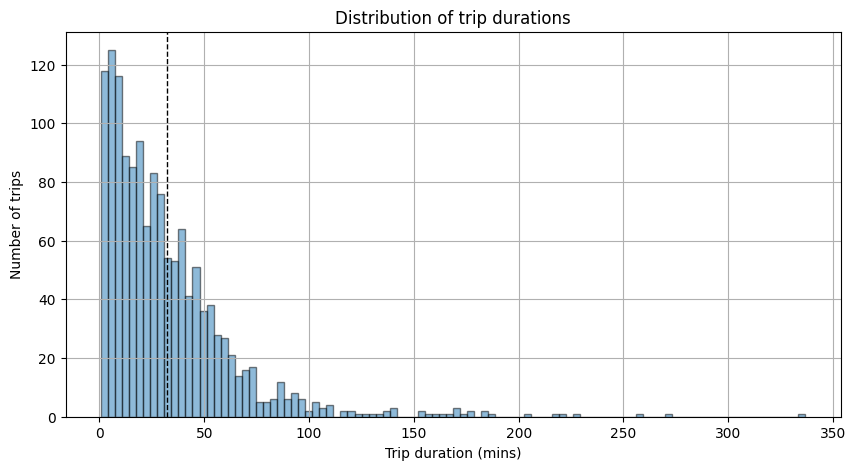


Matching start and end points with tessellation...
Done.

Extracting trips that start and end within tessellation area...
Number of trips that start and end wihin tessellation area: 1375
Number of trips outside and therefore dropped: 33
Done.

Building mapping of trip chains...


100%|███████████████████████████████████████████████████████████████████████████████| 1375/1375 [00:16<00:00, 82.74it/s]


Done.

Evaluating trip chaining...
Number of edges (matched) between trips: 476
Number of wrong matches: 20
Done.

Building trip chains...


100%|████████████████████████████████████████████████████████████████████████████| 1375/1375 [00:00<00:00, 27038.33it/s]


Done.

Merging trips...


100%|██████████████████████████████████████████████████████████████████████████████| 1375/1375 [00:12<00:00, 114.03it/s]


Done.
Number of trips that were matched at least once: 1358/1375
Concatenating MERGED and UNMERGED trips...
Done.

Extracting data for concatenated trips...
Done.

Building clustering after concatenation...
Number of unique clusters: 916
Done.

Building HL from start points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 81 disconnected components.
 There are 46 islands with ids: 1, 4, 5, 6, 24, 29, 33, 37, 38, 39, 40, 45, 46, 47, 48, 49, 57, 58, 59, 70, 84, 91, 92, 96, 98, 99, 102, 103, 113, 114, 115, 117, 118, 119, 120, 123, 137, 138, 158, 159, 178, 179, 182, 185, 186, 198.
  warnings.warn(message)


Done.

Building HL from end points...


/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 124 disconnected components.
 There are 51 islands with ids: 4, 23, 37, 50, 51, 52, 53, 59, 60, 98, 115, 116, 126, 127, 129, 130, 132, 136, 148, 150, 156, 157, 158, 167, 199, 200, 203, 218, 225, 226, 239, 241, 244, 245, 262, 263, 269, 300, 302, 317, 318, 321, 329, 347, 355, 357, 387, 392, 406, 414, 422.
  warnings.warn(message)
/usr/local/lib/python3.8/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 147 disconnected components.
 There are 59 islands with ids: 7, 68, 106, 144, 145, 147, 154, 155, 204, 238, 239, 246, 247, 259, 265, 273, 276, 291, 292, 295, 306, 313, 322, 323, 326, 337, 356, 357, 367, 368, 369, 370, 383, 390, 391, 408, 409, 420, 421, 437, 463, 468, 472, 474, 482, 484, 485, 497, 498, 531, 532, 537, 538, 543, 557, 564, 573, 592, 613.
  warnings.warn(message)


Done.

Combining HL from start points and end points...
Number of users for which at least on Home Location has been identified:  66
Number of unique HL tiles: 147
Done.

Matching trips to HL...
Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 87/916
Number of trajectories (concatenated) that start AND end in a HL tile: 487/916
Number of trips that match different HL tiles with their SP and EP: 240
Done.

Matching double assigned trips to unique HL...


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.
[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-4)]: Done 480 out of 480 | elapsed:  1.2min finished
[Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


All scores are 0.0, assigning -1 as best_hl_id!
All scores are 0.0, assigning -1 as best_hl_id!
Done.

Getting trajectories that happened during the same time...


[Parallel(n_jobs=-4)]: Done 200 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-4)]: Done 550 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-4)]: Done 916 out of 916 | elapsed:  2.1min finished


Done.

Building clustering after HL matching step...


 11%|█████████▎                                                                        | 11/97 [00:00<00:00, 102.45it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 400 iterations with 109 trajectories...


[Parallel(n_jobs=-4)]: Done 400 out of 400 | elapsed:    0.6s finished
 29%|███████████████████████▉                                                           | 28/97 [00:00<00:02, 28.51it/s]

Done. Length of longest subset:  24


 41%|██████████████████████████████████▏                                                | 40/97 [00:01<00:01, 41.86it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Running randomized subset search for 400 iterations with 46 trajectories...


[Parallel(n_jobs=-4)]: Done 400 out of 400 | elapsed:    0.5s finished
 58%|███████████████████████████████████████████████▉                                   | 56/97 [00:01<00:01, 32.90it/s][Parallel(n_jobs=-4)]: Using backend LokyBackend with 125 concurrent workers.


Done. Length of longest subset:  26
Running randomized subset search for 400 iterations with 44 trajectories...


[Parallel(n_jobs=-4)]: Done 400 out of 400 | elapsed:    0.5s finished
 72%|███████████████████████████████████████████████████████████▉                       | 70/97 [00:02<00:00, 27.47it/s]

Done. Length of longest subset:  34


100%|███████████████████████████████████████████████████████████████████████████████████| 97/97 [00:02<00:00, 34.66it/s]


Done.

Clustering results after concatenation step:
Number of unique clusters: 916
Homogeneity: 0.995
Completeness: 0.585
V-measure: 0.736
Rand index: 0.978
ARI: 0.058
MI: 3.911
NMI: 0.736
AMI: 0.263
Cluster accuracy: 0.145

Clustering results after HL matching step:
Number of unique clusters: 314
Homogeneity: 0.895
Completeness: 0.725
V-measure: 0.802
Rand index: 0.982
ARI: 0.494
MI: 3.522
NMI: 0.802
AMI: 0.663
Cluster accuracy: 0.556

Assigning trips without match...
Comparing trips that were not assigned to any HL_ID with trips that were assigned to a HL_ID...



  0%|                                                                                           | 0/219 [00:00<?, ?it/s]

There are two or more HL_IDs with the same LCSS score. Looking for second highest LCSS score...
Candidate HL_IDs: [-1.0, 28.0, 108.0, 117.0, 132.0, 143.0]



  0%|▍                                                                                  | 1/219 [00:11<41:35, 11.45s/it]

Found best HL_ID after comparing candidates: -1.0
no match and assign new cluster id 315 to trips 89 159


  0%|▎                                                                                | 1/219 [00:30<1:52:34, 30.98s/it]


KeyboardInterrupt: 

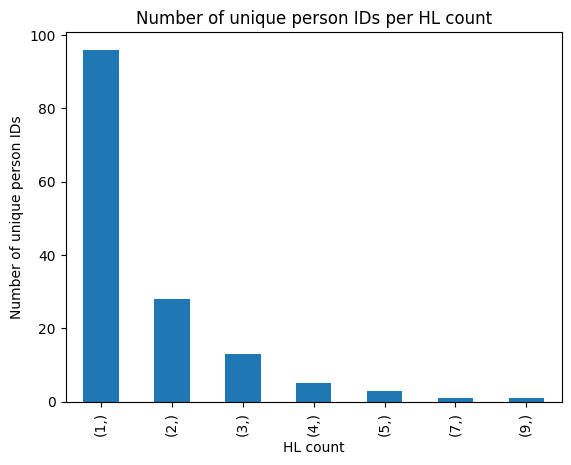

In [6]:
attack.run_full_attack(raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf, city='berlin')